## DCLSTM_Train_and_Weight

In [1]:
import functions as f
from tensorflow.python.keras import backend as k
import csv
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from numpy import argmax
import pickle

Using TensorFlow backend.


In [2]:
'''convert_to_dt'''

#source_path= "D:/USC/Lab/ChamSim/data/654.out"
#f.convert_to_dt(source_path)


'convert_to_dt'

In [2]:

'''read_dt'''
#source_path= "D:/USC/Lab/ChamSim/data/dt.csv"
'''
source_path= "/home/pengmiao/Project/MEMSYS/my_ChampSim_gen_trace/results_8M_dt/605.mcf_s-665B-dt-600k.csv"
dataset_dt = pd.read_csv(source_path, header=None, index_col=None)
dataset_dt_ls=list(dataset_dt[0])[0:400000]

dataset_dt_ls_x = ["%s%d" % ("1x" if x < 0 else "0x", abs(x)) for x in dataset_dt_ls]
'''
source_path= "/home/pengmiao/Project/MEMSYS/my_ChampSim_gen_trace/dt_PARSEC_x.csv"
dataset_dt_ls = pd.read_csv(source_path, header=None, index_col=None)
#print(dataset_dt_ls)
dataset_dt_ls_x=list(dataset_dt_ls[0])[0:]
#print(dataset_dt_ls_x[0:100])

'''tokenize'''
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset_dt_ls_x)
encoded_final = tokenizer.texts_to_sequences([' '.join(dataset_dt_ls_x)])[0]
final_vocab_size = len(tokenizer.word_index) + 1
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
'''input sequence window'''
look_back = 3
sequences = f.create_windowed_dataset(encoded_final, look_back)

'''Training data preprocessing'''
X, y = sequences[:, :-1], sequences[:, -1]
y = y.reshape(len(y), 1)
print(X.shape,y.shape)
'''binay'''
X_binary =f.convert_to_binary(data=X)
y_binay=f.convert_to_binary(data=y)
print(X_binary.shape,y_binay.shape)
X=X_binary
'''split'''
'''test'''
test_ratio=0.15
X_train0, X_test = train_test_split(X, test_size=test_ratio, shuffle=False)
y_train0, y_test = train_test_split(y_binay, test_size=test_ratio, shuffle=False)

'''train, validation'''
test_ratio=0.2
X_train, X_val = train_test_split(X_train0, test_size=test_ratio, shuffle=False)
y_train, y_val = train_test_split(y_train0, test_size=test_ratio, shuffle=False)

print("X shape:",X_train.shape,X_val.shape,X_test.shape)
print("y shape:",y_train.shape,y_val.shape,y_test.shape)

(399997, 3) (399997, 1)
(399997, 48) (399997, 16)
X shape: (271997, 48) (68000, 48) (60000, 48)
y shape: (271997, 16) (68000, 16) (60000, 16)


In [5]:
np.save("X_test.npy",X_test)

In [6]:
X_load=np.load("X_test.npy")
X_load[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0])

In [7]:
X_binary.shape

(399997, 48)

In [8]:
y_binay[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

# Time test

In [141]:
from my_model import my_model
'''train model'''
model_file_name='my_model_dc_parsec_128.h5'
final_vocab_size=2
embedding_dim=8
i_dim=look_back*16
o_dim=y_train.shape[1]
batch_size=256
num_epochs=10
lstm_size=128
model_ = my_model(final_vocab_size, batch_size,embedding_dim, i_dim, o_dim,lstm_size)
history=model_.train(X_train, y_train,X_val, y_val, num_epochs, batch_size)
model_.model.save(model_file_name)
y_pred = model_.predict(X_test)
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0
aaaaa = f.convert_binary_to_dec(y_test)
bbbbb = f.convert_binary_to_dec(y_pred)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(np.array(aaaaa), np.array(bbbbb))
print("accuracy:",accuracy)

#bbbbb = np.packbits(np.array(y_pred, dtype=np.bool).reshape(-1, 2, 8)[:, ::-1]).view(np.uint16)
original_testing_diffs,original_predictions_diffs=f.token_back(aaaaa,bbbbb,tokenizer)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 8)             16        
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               70144     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
Total params: 72,224
Trainable params: 72,224
Non-trainable params: 0
_________________________________________________________________


/home/pengmiao/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 271997 samples, validate on 68000 samples
Epoch 1/10
271997/271997 [==============================] - 69s 255us/step - loss: 0.3765 - accuracy: 0.8204 - val_loss: 0.3272 - val_accuracy: 0.8441
Epoch 2/10
271997/271997 [==============================] - 68s 251us/step - loss: 0.2887 - accuracy: 0.8627 - val_loss: 0.2149 - val_accuracy: 0.9055
Epoch 3/10
271997/271997 [==============================] - 68s 249us/step - loss: 0.2158 - accuracy: 0.9000 - val_loss: 0.1663 - val_accuracy: 0.9211
Epoch 4/10
271997/271997 [==============================] - 68s 251us/step - loss: 0.1684 - accuracy: 0.9189 - val_loss: 0.1538 - val_accuracy: 0.9239
Epoch 5/10
271997/271997 [==============================] - 68s 250us/step - loss: 0.1513 - accuracy: 0.9246 - val_loss: 0.1472 - val_accuracy: 0.9249
Epoch 6/10
271997/271997 [==============================] - 68s 251us/step - loss: 0.1462 - accuracy: 0.9262 - val_loss: 0.1496 - val_accuracy: 0.9242
Epoch 7/10
271997/271997 [=================

In [142]:
from my_model import my_model
'''train model'''
model_file_name='my_model_dc_parsec_64.h5'
final_vocab_size=2
embedding_dim=8
i_dim=look_back*16
o_dim=y_train.shape[1]
batch_size=256
num_epochs=10
lstm_size=64
model_ = my_model(final_vocab_size, batch_size,embedding_dim, i_dim, o_dim,lstm_size)
history=model_.train(X_train, y_train,X_val, y_val, num_epochs, batch_size)
model_.model.save(model_file_name)
y_pred = model_.predict(X_test)
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0
aaaaa = f.convert_binary_to_dec(y_test)
bbbbb = f.convert_binary_to_dec(y_pred)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(np.array(aaaaa), np.array(bbbbb))
print("accuracy:",accuracy)

#bbbbb = np.packbits(np.array(y_pred, dtype=np.bool).reshape(-1, 2, 8)[:, ::-1]).view(np.uint16)
original_testing_diffs,original_predictions_diffs=f.token_back(aaaaa,bbbbb,tokenizer)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 48, 8)             16        
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                18688     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
Total params: 19,744
Trainable params: 19,744
Non-trainable params: 0
_________________________________________________________________


/home/pengmiao/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 271997 samples, validate on 68000 samples
Epoch 1/10
271997/271997 [==============================] - 68s 250us/step - loss: 0.3844 - accuracy: 0.8165 - val_loss: 0.3294 - val_accuracy: 0.8428
Epoch 2/10
271997/271997 [==============================] - 68s 250us/step - loss: 0.3111 - accuracy: 0.8477 - val_loss: 0.2737 - val_accuracy: 0.8696
Epoch 3/10
271997/271997 [==============================] - 69s 253us/step - loss: 0.2590 - accuracy: 0.8761 - val_loss: 0.2228 - val_accuracy: 0.9015
Epoch 4/10
271997/271997 [==============================] - 69s 254us/step - loss: 0.2220 - accuracy: 0.8957 - val_loss: 0.1930 - val_accuracy: 0.9129
Epoch 5/10
271997/271997 [==============================] - 67s 247us/step - loss: 0.2013 - accuracy: 0.9053 - val_loss: 0.1744 - val_accuracy: 0.9186
Epoch 6/10
271997/271997 [==============================] - 67s 247us/step - loss: 0.1855 - accuracy: 0.9116 - val_loss: 0.1645 - val_accuracy: 0.9211
Epoch 7/10
271997/271997 [=================

In [143]:
from my_model import my_model
'''train model'''
model_file_name='my_model_dc_parsec_16.h5'
final_vocab_size=2
embedding_dim=8
i_dim=look_back*16
o_dim=y_train.shape[1]
batch_size=256
num_epochs=10
lstm_size=16
model_ = my_model(final_vocab_size, batch_size,embedding_dim, i_dim, o_dim,lstm_size)
history=model_.train(X_train, y_train,X_val, y_val, num_epochs, batch_size)
model_.model.save(model_file_name)

y_pred = model_.predict(X_test)
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0
aaaaa = f.convert_binary_to_dec(y_test)
bbbbb = f.convert_binary_to_dec(y_pred)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(np.array(aaaaa), np.array(bbbbb))
print("accuracy:",accuracy)

#bbbbb = np.packbits(np.array(y_pred, dtype=np.bool).reshape(-1, 2, 8)[:, ::-1]).view(np.uint16)
original_testing_diffs,original_predictions_diffs=f.token_back(aaaaa,bbbbb,tokenizer)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 48, 8)             16        
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                1600      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
Total params: 1,888
Trainable params: 1,888
Non-trainable params: 0
_________________________________________________________________


/home/pengmiao/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 271997 samples, validate on 68000 samples
Epoch 1/10
271997/271997 [==============================] - 69s 253us/step - loss: 0.4064 - accuracy: 0.8106 - val_loss: 0.3607 - val_accuracy: 0.8283
Epoch 2/10
271997/271997 [==============================] - 68s 251us/step - loss: 0.3609 - accuracy: 0.8199 - val_loss: 0.3517 - val_accuracy: 0.8308
Epoch 3/10
271997/271997 [==============================] - 68s 251us/step - loss: 0.3512 - accuracy: 0.8236 - val_loss: 0.3405 - val_accuracy: 0.8387
Epoch 4/10
271997/271997 [==============================] - 68s 252us/step - loss: 0.3376 - accuracy: 0.8306 - val_loss: 0.3248 - val_accuracy: 0.8401
Epoch 5/10
271997/271997 [==============================] - 68s 251us/step - loss: 0.3288 - accuracy: 0.8331 - val_loss: 0.3147 - val_accuracy: 0.8469
Epoch 6/10
271997/271997 [==============================] - 68s 251us/step - loss: 0.3229 - accuracy: 0.8362 - val_loss: 0.3093 - val_accuracy: 0.8499
Epoch 7/10
271997/271997 [=================

In [144]:
from my_model import my_model
'''train model'''
model_file_name='my_model_dc_parsec_32.h5'
final_vocab_size=2
embedding_dim=8
i_dim=look_back*16
o_dim=y_train.shape[1]
batch_size=256
num_epochs=10
lstm_size=32
model_ = my_model(final_vocab_size, batch_size,embedding_dim, i_dim, o_dim,lstm_size)
history=model_.train(X_train, y_train,X_val, y_val, num_epochs, batch_size)
model_.model.save(model_file_name)

y_pred = model_.predict(X_test)
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0
aaaaa = f.convert_binary_to_dec(y_test)
bbbbb = f.convert_binary_to_dec(y_pred)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(np.array(aaaaa), np.array(bbbbb))
print("accuracy:",accuracy)

#bbbbb = np.packbits(np.array(y_pred, dtype=np.bool).reshape(-1, 2, 8)[:, ::-1]).view(np.uint16)
original_testing_diffs,original_predictions_diffs=f.token_back(aaaaa,bbbbb,tokenizer)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 48, 8)             16        
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                5248      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
Total params: 5,792
Trainable params: 5,792
Non-trainable params: 0
_________________________________________________________________


/home/pengmiao/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 271997 samples, validate on 68000 samples
Epoch 1/10
271997/271997 [==============================] - 69s 253us/step - loss: 0.3959 - accuracy: 0.8130 - val_loss: 0.3451 - val_accuracy: 0.8366
Epoch 2/10
271997/271997 [==============================] - 68s 251us/step - loss: 0.3367 - accuracy: 0.8341 - val_loss: 0.3127 - val_accuracy: 0.8500
Epoch 3/10
271997/271997 [==============================] - 68s 251us/step - loss: 0.3120 - accuracy: 0.8436 - val_loss: 0.3133 - val_accuracy: 0.8540
Epoch 4/10
271997/271997 [==============================] - 69s 253us/step - loss: 0.3151 - accuracy: 0.8452 - val_loss: 0.2880 - val_accuracy: 0.8669
Epoch 5/10
271997/271997 [==============================] - 68s 252us/step - loss: 0.2896 - accuracy: 0.8573 - val_loss: 0.2666 - val_accuracy: 0.8742
Epoch 6/10
271997/271997 [==============================] - 68s 251us/step - loss: 0.2747 - accuracy: 0.8656 - val_loss: 0.2488 - val_accuracy: 0.8864
Epoch 7/10
271997/271997 [=================

In [127]:
from tensorflow.keras.models import load_model
model_file_name='my_model_dc_parsec_16.h5'
model_ = load_model(model_file_name)
a=np.array([X_test[0]])


In [140]:
import time
time_start=time.time()
model_.predict(a)
time_end=time.time()
print('32:time cost:',time_end-time_start,'s')

32:time cost: 0.04493975639343262 s


# Time end

In [2]:
from tensorflow.keras.models import load_model
model_file_name='my_model_dc_parsec.h5'
model_ = load_model(model_file_name)
#from keras.utils import plot_model
#plot_model(model_, to_file='my_model_dc_parsec.png')

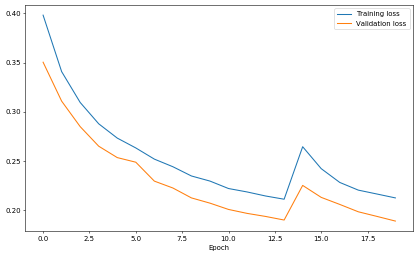

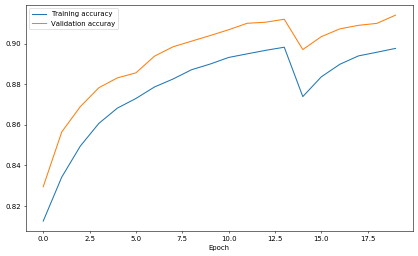

In [11]:
import matplotlib.pyplot as plt
fig1 = plt.figure(dpi=50, figsize=(10, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel("Epoch")
#plt.ylabel("Training loss")
plt.legend(loc="best")
fig2 = plt.figure(dpi=50, figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuray')
plt.xlabel("Epoch")
plt.legend(loc="best")

In [12]:
y_pred = model_.predict(X_test)
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0
aaaaa = f.convert_binary_to_dec(y_test)
bbbbb = f.convert_binary_to_dec(y_pred)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(np.array(aaaaa), np.array(bbbbb))
print("accuracy:",accuracy)

#bbbbb = np.packbits(np.array(y_pred, dtype=np.bool).reshape(-1, 2, 8)[:, ::-1]).view(np.uint16)
original_testing_diffs,original_predictions_diffs=f.token_back(aaaaa,bbbbb,tokenizer)

accuracy: 0.7235833333333334


In [13]:
import time
time_start=time.time()
model_.predict(np.array([X_test[0]]))
time_end=time.time()
print('time cost',time_end-time_start,'s')

time cost 0.018143415451049805 s


In [ ]:
X_test2=np.array([X_test[10]])
y_pred1 = model_.predict(X_test2)
y_pred1[y_pred1 >= 0.5] = 1
y_pred1[y_pred1 < 0.5] = 0

a1=[0]
b1 = f.convert_binary_to_dec(y_pred1)
diff,nomean=f.token_back(b1,b1,tokenizer)
print(diff)

# Weights

In [2]:
model_.layers

In [4]:
print("embedding:",model_.layers[0].get_weights()[0].shape)

embedding: (2, 8)


In [5]:
print("embedding:",model_.layers[0].get_weights()[0])

embedding: [[ 0.1511789   0.21257462  0.02249864  0.05298556  0.3013374   0.04191065
   0.20380408  0.01847126]
 [-0.58739895 -0.8522611  -0.12063408 -0.9246319  -1.0010942  -0.925209
  -0.6365828  -0.16443335]]


this means :

if the value is 0, replaced by (or map to) [ 0.17540154  0.2772978   0.15073669  0.0390941  -0.13905676 -0.21958843
   0.14507203 -0.0971421   0.32921442  0.1110358 ];
   
if the value is 1, replaced by (or map to) [-0.40535894 -0.75318736 -0.6593158  -0.79442096  0.5156072   0.34559667
  -0.14990288  0.377039   -0.71279496 -0.5381763 ]
  
  https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work

In [8]:

print("lstm:",np.array(model_.layers[1].get_weights()).shape)
print("lstm_0:",model_.layers[1].get_weights()[0].shape)
print("lstm_1:",model_.layers[1].get_weights()[1].shape)
print("lstm_2:",model_.layers[1].get_weights()[2].shape)
print("total: 12200")

lstm: (3,)
lstm_0: (8, 128)
lstm_1: (32, 128)
lstm_2: (128,)
total: 12200


## LSMT Weight

https://stackoverflow.com/questions/42861460/how-to-interpret-weights-in-a-lstm-layer-in-keras

In [ ]:
#print(model_.layers[1].trainable_weights)
units = int(int(model_.layers[1].trainable_weights[0].shape[1])/4)
print("No. units: ", units)

W = model_.layers[1].get_weights()[0]
U = model_.layers[1].get_weights()[1]
b = model_.layers[1].get_weights()[2]

W_i = W[:, :units]
W_f = W[:, units: units * 2]
W_c = W[:, units * 2: units * 3]
W_o = W[:, units * 3:]

U_i = U[:, :units]
U_f = U[:, units: units * 2]
U_c = U[:, units * 2: units * 3]
U_o = U[:, units * 3:]

b_i = b[:units]
b_f = b[units: units * 2]
b_c = b[units * 2: units * 3]
b_o = b[units * 3:]

In [ ]:
print("dropout:",model_.layers[2].get_weights())

In [ ]:
print("dense:",model_.layers[3].get_weights()[0].shape)
print("dense_bias:",model_.layers[3].get_weights()[1].shape)

In [ ]:
print("dropout:",model_.layers[4].get_weights())
print("dense:",model_.layers[5].get_weights()[0].shape)
print("dense_bias:",model_.layers[5].get_weights()[1].shape)

In [ ]:
print(W_i.shape,U_i.shape,b_i.shape)
print(W_f.shape,U_f.shape,b_f.shape)
# https://stackoverflow.com/questions/42861460/how-to-interpret-weights-in-a-lstm-layer-in-keras

## Dense

In [11]:
print("embedding:",model_.layers[3].get_weights()[0].shape)
print("embedding:",model_.layers[3].get_weights()[1].shape)

embedding: (32, 16)
embedding: (16,)
